# Domain adaptation

- Unsupervised Domain Adaptation by Backpropagation, Ganin & Lemptsky (2014)


![](da.png)

https://www.youtube.com/watch?v=uUUvieVxCMs&t=1210s

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Function
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import mnistm
from PIL import Image

In [2]:
class GrayscaleToRgb:
    """Convert a grayscale image to rgb"""
    def __call__(self, image):
        image = np.array(image)
        image = np.dstack([image, image, image])
        return Image.fromarray(image)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(2),
            nn.Dropout2d(),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(x.shape[0], -1)
        logits = self.classifier(features)
        return logits

In [4]:
# Taken from https://github.com/jvanvugt/pytorch-domain-adaptation/
class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """
    
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None

class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

In [5]:
epochs=50
seed = 1101
batch_size = 64

use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [6]:
model = Net().to(device)
model.load_state_dict(torch.load('conv_for_domain_adaptation.pt'))

In [7]:
feature_extractor = model.feature_extractor
clf = model.classifier

discriminator = nn.Sequential(
    GradientReversal(),
    nn.Linear(320, 50),
    nn.ReLU(),
    nn.Linear(50, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
).to(device)

In [8]:
half_batch = batch_size // 2

source_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           GrayscaleToRgb(),
                           transforms.ToTensor(),                           
                       ])),
        batch_size=half_batch, shuffle=True, **kwargs)

In [9]:
target_loader = torch.utils.data.DataLoader( 
    mnistm.MNISTM('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),                           
                       ])), 
    batch_size=half_batch, shuffle=True, **kwargs)

In [10]:
imgs,labels = next(iter(target_loader))
print(imgs.shape)

torch.Size([32, 3, 28, 28])


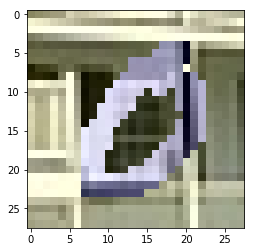

In [11]:
plt.imshow(np.transpose(imgs[19], (1,2,0)))
plt.show()

In [12]:
optim = torch.optim.Adam(list(discriminator.parameters()) + list(model.parameters()))

In [13]:
for epoch in range(1, epochs+1):
    batches = zip(source_loader, target_loader)
    n_batches = min(len(source_loader), len(target_loader))

    total_domain_loss = total_label_accuracy = 0
    for (source_x, source_labels), (target_x, _) in tqdm(batches, leave=False, total=n_batches):
            x = torch.cat([source_x, target_x])
            x = x.to(device)
            domain_y = torch.cat([torch.ones(source_x.shape[0]),
                                  torch.zeros(target_x.shape[0])])
            domain_y = domain_y.to(device)
            label_y = source_labels.to(device)

            features = feature_extractor(x).view(x.shape[0], -1)
            domain_preds = discriminator(features).squeeze()
            label_preds = clf(features[:source_x.shape[0]])

            domain_loss = F.binary_cross_entropy_with_logits(domain_preds, domain_y)
            label_loss = F.cross_entropy(label_preds, label_y)
            loss = domain_loss + label_loss

            optim.zero_grad()
            loss.backward()
            optim.step()

            total_domain_loss += domain_loss.item()
            total_label_accuracy += (label_preds.max(1)[1] == label_y).float().mean().item()

    mean_loss = total_domain_loss / n_batches
    mean_accuracy = total_label_accuracy / n_batches
    tqdm.write(f'EPOCH {epoch:03d}: domain_loss={mean_loss:.4f}, '
               f'source_accuracy={mean_accuracy:.4f}')

    torch.save(model.state_dict(), 'domain_adaptation/revgrad_' + str(epoch) + '.pt')


  0%|          | 2/1875 [00:00<01:34, 19.87it/s]   

EPOCH 001: domain_loss=0.4521, source_accuracy=0.9002


  0%|          | 2/1875 [00:00<01:37, 19.30it/s]   

EPOCH 002: domain_loss=0.5404, source_accuracy=0.9124


  0%|          | 3/1875 [00:00<01:18, 23.86it/s]   

EPOCH 003: domain_loss=0.5477, source_accuracy=0.9223


  0%|          | 4/1875 [00:00<01:00, 30.91it/s]   

EPOCH 004: domain_loss=0.5273, source_accuracy=0.9259


  0%|          | 3/1875 [00:00<01:08, 27.16it/s]   

EPOCH 005: domain_loss=0.5131, source_accuracy=0.9294


  0%|          | 4/1875 [00:00<01:00, 30.94it/s]   

EPOCH 006: domain_loss=0.5074, source_accuracy=0.9330


  0%|          | 4/1875 [00:00<01:00, 30.93it/s]   

EPOCH 007: domain_loss=0.5072, source_accuracy=0.9345


  0%|          | 3/1875 [00:00<01:02, 29.73it/s]   

EPOCH 008: domain_loss=0.5106, source_accuracy=0.9344


  0%|          | 3/1875 [00:00<01:03, 29.33it/s]   

EPOCH 009: domain_loss=0.5153, source_accuracy=0.9352


  0%|          | 3/1875 [00:00<01:03, 29.51it/s]   

EPOCH 010: domain_loss=0.5155, source_accuracy=0.9351


  0%|          | 4/1875 [00:00<01:01, 30.52it/s]   

EPOCH 011: domain_loss=0.5138, source_accuracy=0.9374


  0%|          | 4/1875 [00:00<01:00, 31.03it/s]   

EPOCH 012: domain_loss=0.5199, source_accuracy=0.9376


  0%|          | 4/1875 [00:00<00:59, 31.30it/s]   

EPOCH 013: domain_loss=0.5153, source_accuracy=0.9398


  0%|          | 4/1875 [00:00<00:58, 32.04it/s]   

EPOCH 014: domain_loss=0.5193, source_accuracy=0.9376


  0%|          | 4/1875 [00:00<00:58, 31.93it/s]   

EPOCH 015: domain_loss=0.5139, source_accuracy=0.9396


  0%|          | 4/1875 [00:00<00:57, 32.40it/s]   

EPOCH 016: domain_loss=0.5162, source_accuracy=0.9393


  0%|          | 4/1875 [00:00<00:58, 31.88it/s]   

EPOCH 017: domain_loss=0.5163, source_accuracy=0.9366


  0%|          | 4/1875 [00:00<00:57, 32.43it/s]   

EPOCH 018: domain_loss=0.5169, source_accuracy=0.9397


  0%|          | 4/1875 [00:00<00:57, 32.78it/s]   

EPOCH 019: domain_loss=0.5181, source_accuracy=0.9408


  0%|          | 3/1875 [00:00<01:02, 29.80it/s]   

EPOCH 020: domain_loss=0.5168, source_accuracy=0.9414


  0%|          | 4/1875 [00:00<00:58, 31.90it/s]   

EPOCH 021: domain_loss=0.5164, source_accuracy=0.9401


  0%|          | 4/1875 [00:00<00:57, 32.26it/s]   

EPOCH 022: domain_loss=0.5155, source_accuracy=0.9407


  0%|          | 3/1875 [00:00<01:10, 26.41it/s]   

EPOCH 023: domain_loss=0.5159, source_accuracy=0.9426


  0%|          | 2/1875 [00:00<01:38, 19.10it/s]   

EPOCH 024: domain_loss=0.5163, source_accuracy=0.9417


  0%|          | 3/1875 [00:00<01:12, 25.78it/s]   

EPOCH 025: domain_loss=0.5157, source_accuracy=0.9409


  0%|          | 3/1875 [00:00<01:13, 25.40it/s]   

EPOCH 026: domain_loss=0.5183, source_accuracy=0.9423


  0%|          | 3/1875 [00:00<01:04, 29.10it/s]   

EPOCH 027: domain_loss=0.5168, source_accuracy=0.9423


  0%|          | 3/1875 [00:00<01:11, 26.05it/s]   

EPOCH 028: domain_loss=0.5167, source_accuracy=0.9427


  0%|          | 3/1875 [00:00<01:05, 28.67it/s]   

EPOCH 029: domain_loss=0.5137, source_accuracy=0.9437


  0%|          | 3/1875 [00:00<01:11, 26.25it/s]   

EPOCH 030: domain_loss=0.5146, source_accuracy=0.9445


  0%|          | 3/1875 [00:00<01:18, 23.80it/s]   

EPOCH 031: domain_loss=0.5185, source_accuracy=0.9429


  0%|          | 3/1875 [00:00<01:06, 28.09it/s]   

EPOCH 032: domain_loss=0.5188, source_accuracy=0.9449


  0%|          | 3/1875 [00:00<01:09, 26.79it/s]   

EPOCH 033: domain_loss=0.5191, source_accuracy=0.9420


  0%|          | 3/1875 [00:00<01:13, 25.32it/s]   

EPOCH 034: domain_loss=0.5180, source_accuracy=0.9433


  0%|          | 3/1875 [00:00<01:16, 24.35it/s]   

EPOCH 035: domain_loss=0.5180, source_accuracy=0.9425


  0%|          | 3/1875 [00:00<01:04, 28.82it/s]   

EPOCH 036: domain_loss=0.5196, source_accuracy=0.9426


  0%|          | 4/1875 [00:00<00:58, 32.14it/s]   

EPOCH 037: domain_loss=0.5186, source_accuracy=0.9431


  0%|          | 3/1875 [00:00<01:07, 27.55it/s]   

EPOCH 038: domain_loss=0.5171, source_accuracy=0.9450


  0%|          | 3/1875 [00:00<01:06, 27.96it/s]   

EPOCH 039: domain_loss=0.5188, source_accuracy=0.9429


  0%|          | 3/1875 [00:00<01:02, 29.84it/s]   

EPOCH 040: domain_loss=0.5175, source_accuracy=0.9441


  0%|          | 3/1875 [00:00<01:09, 26.94it/s]   

EPOCH 041: domain_loss=0.5164, source_accuracy=0.9447


  0%|          | 3/1875 [00:00<01:03, 29.50it/s]   

EPOCH 042: domain_loss=0.5202, source_accuracy=0.9433


  0%|          | 3/1875 [00:00<01:05, 28.45it/s]   

EPOCH 043: domain_loss=0.5227, source_accuracy=0.9431


  0%|          | 3/1875 [00:00<01:20, 23.13it/s]   

EPOCH 044: domain_loss=0.5183, source_accuracy=0.9455


  0%|          | 3/1875 [00:00<01:12, 25.74it/s]   

EPOCH 045: domain_loss=0.5207, source_accuracy=0.9431


  0%|          | 3/1875 [00:00<01:12, 25.83it/s]   

EPOCH 046: domain_loss=0.5199, source_accuracy=0.9426


  0%|          | 2/1875 [00:00<01:42, 18.22it/s]   

EPOCH 047: domain_loss=0.5200, source_accuracy=0.9457


  0%|          | 3/1875 [00:00<01:08, 27.51it/s]   

EPOCH 048: domain_loss=0.5225, source_accuracy=0.9448


  0%|          | 3/1875 [00:00<01:11, 26.14it/s]   

EPOCH 049: domain_loss=0.5217, source_accuracy=0.9438


EPOCH 050: domain_loss=0.5245, source_accuracy=0.9442


# Exercise

- Assess the performance of the model through all epochs on source and target dataset. You should define new loaders with a suitable batch size. Pay attention to the case of the source dataset. Plot the accuracy on source and target domains as a function of the epoch, including the 0 epoch, before domain adaptation.

- Visualize features before and after domain adaptation with T-SNE. Is it visible the feature adaptation?

- Compute the ID of source and target features beore and  during the domain adaptation. What do you expect to see?

# Assess performance

In [14]:
nsamples=1000

# this should be on test set
sample_source_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True,
                       transform=transforms.Compose([
                           GrayscaleToRgb(),
                           transforms.ToTensor(),                                                
                       ])),
        batch_size=nsamples, shuffle=True, **kwargs)

# this is (almost) indifferent
sample_target_loader = torch.utils.data.DataLoader( 
    mnistm.MNISTM('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),                           
                       ])), 
    batch_size=nsamples, shuffle=True, **kwargs)

In [15]:
imgs_source, labels_source = next(iter(sample_source_loader))
imgs_target, labels_target = next(iter(sample_target_loader))

In [16]:
source_acc = []
target_acc = []

for epoch in range(epochs + 1):
    
    if epoch == 0:
        model.load_state_dict(torch.load('conv_for_domain_adaptation.pt'))
    else:
        model.load_state_dict(torch.load('./domain_adaptation/revgrad_' + str(epoch) + '.pt') )
    model.eval()

    out = model(imgs_source)
    acc = (out.max(1)[1] == labels_source).float().mean().item()
    source_acc.append(acc)
    #print('Source accuracy: {}'.format(acc) )

    out = model(imgs_target)
    acc = (out.max(1)[1] == labels_target).float().mean().item()
    #print('Target accuracy: {}'.format(acc) )
    target_acc.append(acc)

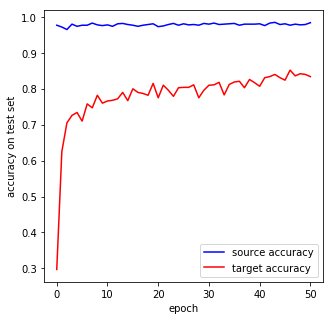

In [18]:
fig=plt.figure(figsize=(5,5))
plt.plot(source_acc,'-b',label='source accuracy')
plt.plot(target_acc,'-r',label='target accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy on test set')
plt.legend()
plt.show()

# Visualization of features adaptation with T-SNE

In [19]:
model.load_state_dict(torch.load('conv_for_domain_adaptation.pt'))
model.eval()

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.5)
  )
  (classifier): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [20]:
Feats_source = []
Feats_source.append( model.feature_extractor(imgs_source).view(nsamples,-1) )

Feats_target = []
Feats_target.append( model.feature_extractor(imgs_target).view(nsamples,-1) )

In [22]:
epoch = epochs
model.load_state_dict(torch.load('./domain_adaptation/revgrad_' + str(epoch) + '.pt') )
model.eval()

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.5)
  )
  (classifier): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [23]:
Feats_source.append( model.feature_extractor(imgs_source).view(nsamples,-1) )
Feats_target.append( model.feature_extractor(imgs_target).view(nsamples,-1) )

In [ ]:
#for i in range(epochs):
#    model.load_state_dict(torch.load('./domain_adaptation/revgrad_' + str(epoch) + '.pt') )
#    model.eval()
    
#    Feats_source.append( model.feature_extractor(imgs_source).view(nsamples,-1) )
#    Feats_target.append( model.feature_extractor(imgs_target).view(nsamples,-1) )

In [24]:
from sklearn.manifold import TSNE

In [25]:
TSNE_source = []
TSNE_source.append(TSNE(n_components=2).fit_transform(Feats_source[0].detach().numpy()))

TSNE_target = []
TSNE_target.append(TSNE(n_components=2).fit_transform(Feats_target[0].detach().numpy()))

In [26]:
TSNE_source.append(TSNE(n_components=2).fit_transform(Feats_source[1].detach().numpy()))
TSNE_target.append(TSNE(n_components=2).fit_transform(Feats_target[1].detach().numpy()))

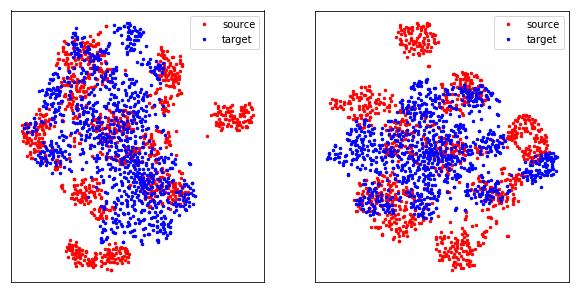

In [31]:
tags = ['source','target']
fig=plt.figure(figsize=(10,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    X = TSNE_source[i]
    Y = TSNE_target[i]
    plt.plot(X[:,0], X[:,1], '.r', markersize=5, label=tags[0])
    plt.plot(Y[:,0], Y[:,1], '.b', markersize=5, label=tags[1])
    plt.xticks([])
    plt.yticks([])
    plt.legend()

plt.show()